In [4]:
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import skops.io as sio

In [6]:
bank_df = pd.read_csv("train.csv", index_col="id", nrows=1000)
bank_df = bank_df.drop(["CustomerId", "Surname"], axis=1)
bank_df = bank_df.sample(frac=1)


# Splitting data into training and testing sets
X = bank_df.drop(["Exited"], axis=1)
y = bank_df.Exited

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

# Identify numerical and categorical columns
cat_col = [1, 2]
num_col = [0, 3, 4, 5, 6, 7, 8, 9]

# Transformers for numerical data
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", MinMaxScaler())]
)

# Transformers for categorical data
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder()),
    ]
)

# Combine pipelines using ColumnTransformer
preproc_pipe = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, num_col),
        ("cat", categorical_transformer, cat_col),
    ],
    remainder="passthrough",
)

In [30]:
KBest = SelectKBest(chi2, k="all")

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=125)

# KBest and model pipeline
train_pipe = Pipeline(
    steps=[
        ("KBest", KBest),
        ("RFmodel", model),
    ]
)

# Combining the preprocessing and training pipelines
complete_pipe = Pipeline(
    steps=[
        ("preprocessor", preproc_pipe),
        ("train", train_pipe),
    ]
)

# running the complete pipeline
complete_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  [0, 3, 4, 5, 6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  [1, 2])])),
                ('train',
                 Pipeline(steps=[('KBest',
                                  SelectKBest(k='all',
                                              score_func=<function chi2 at 0x1681ce520>)),
                                 ('RFmodel',
                                  RandomForestClassifier(random_state=125))]))])

In [32]:
predictions = complete_pipe.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))


Accuracy: 85.0% F1: 0.7


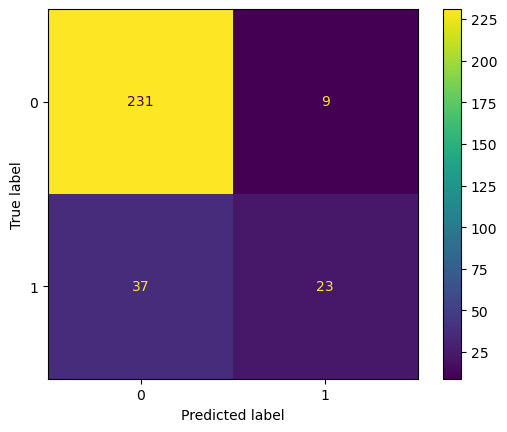

In [34]:
predictions = complete_pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=complete_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=complete_pipe.classes_)
disp.plot()
plt.savefig("model_results.png", dpi=120)

In [36]:
with open("metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}\n\n")
   

# saving the pipeline
sio.dump(complete_pipe, "bank_pipeline.skops")